#### ЛЕГЕНДА
Анализ мобильной игры Quiz Freeze.
Необходимо исследовать поведение пользователей в обновлённом приложении и проверить несколько гипотез.

**Гипотеза 1.**
По идее, должна быть разница в поведении групп, которые проходят и не проходят обучение. Но так ли это? Влияет ли обучение на скорость прохождения других этапов игры?

**Гипотеза 2.**
Кажется, повторное прохождение обучения положительно влияет на оплату, верно?

**Гипотеза 3.**
Если пользователь сначала выбирает сложность обучения, будет ли он потом проходить обучение?


##### ЗАДАЧИ:
В рамках проверки гипотез необходимо решить три задачи:

1. Определить, насколько обучение сокращает время прохождения этапов игры.
2. Доказать, что успешное обучение само по себе влияет на оплату и не имеет значения то, каким этапом оно шло.
3. Определить, насколько прозрачен процесс взаимодействия с игрой.

##### КОНКРЕТНЫЕ ШАГИ (ФОРМАЛИЗОВАННЫЕ ЗАДАЧИ):
1. Сравнить время прохождения различных этапов для пользователей, которые завершили обучение, и пользователей, не начинавших обучение. Если показатель отличается, выяснить, насколько.
2. Проверить, существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь. 
3. Выяснить, как часто пользователи начинают обучение после выбора уровня сложности. (Это позволит оценить прозрачность процесса взаимодействия с игрой: если пользователи после выбора уровня сложности обращаются к обучению, значит, работа с приложением непонятна.)

##### Загружаем библиотеки:

In [114]:
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px

##### Загружаем файлы:

In [115]:
events_df = pd.read_csv('7_4_Events.csv')
purchase_df = pd.read_csv('purchase.csv')

Ссылки на исходные файлы:
*   [7_4_Events.csv
](https://drive.google.com/file/d/1aWd5HtWQg3HOwpOZAZb-NBrURAFnMHMM/view?usp=sharing)
*   [purchase.csv
](https://drive.google.com/file/d/1j6L6tdxvlYi9p5c2eq7ENNuDx0m0ptpe/view?usp=sharing)

##### Проводим обработку данных:

Делаем выборку по условию: пользователи зарегистрировались в 2018 году (с 1 января по 31 декабря 2018 года включительно). Фильтруем датафреймы с событиями и покупками по данному условию.

In [116]:
registered_in_2018 = events_df[(events_df.event_type == 'registration') & 
                               (events_df.start_time >= '2018-01-01') &
                               (events_df.start_time < '2019-01-01')
].user_id.to_list()
events_2018 = events_df[events_df.user_id.isin(registered_in_2018)].copy()
purchases_2018 = purchase_df[purchase_df.user_id.isin(registered_in_2018)].copy()

Переводим столбцы со временем событий в формат datetime:

In [117]:
events_2018.start_time = pd.to_datetime(events_2018.start_time)
purchases_2018.event_datetime = pd.to_datetime(purchases_2018.event_datetime)

Переименуем колонки с id события и добавим название операции покупки в столбец event_type, чтобы объеденить две таблицы в одну:

In [118]:
events_2018 = events_2018.rename(columns={'id':'event_id'})
purchases_2018 = purchases_2018.rename(
    columns={'id':'event_id',
             'event_datetime': 'start_time'}
)
purchases_2018['event_type'] = 'purchase'

In [119]:
total_events_2018 = pd.concat([events_2018, purchases_2018], sort=False)
total_events_2018.reset_index(drop=True).sort_values('start_time')
total_events_2018.head(10)

,event_id,event_type,selected_level,start_time,tutorial_id,user_id,amount
51405,80308,registration,NaN,2018-01-01 03:48:40,NaN,27832,NaN
51406,80309,registration,NaN,2018-01-01 04:07:25,NaN,27833,NaN
51407,80310,registration,NaN,2018-01-01 08:35:10,NaN,27834,NaN
51408,80311,registration,NaN,2018-01-01 11:54:47,NaN,27835,NaN
51409,80312,registration,NaN,2018-01-01 13:28:07,NaN,27836,NaN
51410,80313,registration,NaN,2018-01-01 14:08:40,NaN,27837,NaN
51411,80314,registration,NaN,2018-01-01 14:42:58,NaN,27838,NaN
51412,80315,tutorial_start,NaN,2018-01-01 14:54:40,31505.0,27836,NaN
51413,80316,tutorial_start,NaN,2018-01-01 15:00:51,31506.0,27835,NaN
51414,80317,tutorial_finish,NaN,2018-01-01 15:06:15,31506.0,27835,NaN


Разбиваем пользователей на группы по признаку прохождения различных этапов.

In [120]:
all_users = total_events_2018.user_id.unique()
users_with_started_tutorial = total_events_2018[total_events_2018.event_type == 'tutorial_start'].user_id.to_list()
users_with_finished_tutorial = total_events_2018[total_events_2018.event_type == 'tutorial_finish'].user_id.to_list()
users_not_started_tutorial = total_events_2018[~total_events_2018.user_id.isin(users_with_started_tutorial)].user_id.to_list()


Считаем количество уникальных пользователей на каждом этапе при помощи сводной таблицы и строим воронку конверсии.

In [121]:
users_by_stages = total_events_2018.pivot_table(
    index='event_type',
    values='user_id',
    aggfunc='nunique'
).reset_index(drop=False).rename(columns={'user_id': 'user_count', 'event_type': 'stage'}).sort_values(by='user_count', ascending=False)

In [122]:
# Визуализируем в виде воронки.
fig = px.funnel(users_by_stages, x='user_count', y='stage', width=800, height=500, title='Воронка конверсии пользователей')
fig.show("png")

ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


Не все начавшие обучение пользователи прошли его до конца. 

Проверяем, есть ли повторы событий.

In [ ]:
print(total_events_2018[total_events_2018.event_type == 'tutorial_start'].user_id.value_counts().mean())
print(total_events_2018[total_events_2018.event_type == 'tutorial_finish'].user_id.value_counts().mean())
print(total_events_2018[total_events_2018.event_type == 'level_choice'].user_id.value_counts().mean())
print(total_events_2018[total_events_2018.event_type == 'pack_choice'].user_id.value_counts().mean())

1.522179119581717
1.4540487804878048
1.0
1.0


Как мы видим, некоторые пользователи несколько раз проходили обучение. В дальнейшем рассмотрим это подробнее.

Создадим дополнительный столбец с указанием группы пользователей.

In [ ]:
def group_identification(user):
    if user in users_with_finished_tutorial:
        return 'finished_tutorial'
    elif user in users_not_started_tutorial:
        return 'not_started_tutorial'
    else:
        return 'not_finished_tutorial'

total_events_2018['user_group'] = total_events_2018.user_id.apply(group_identification)

#### Гипотеза №1:


Создаем сводную таблицу для каждого пользователя и времени всех действий, совершенных пользователем, выбирая самое первое действие в рамках каждого этапа, чтобы убрать повторы. Преобразуем сводную таблицу в обычный датафрейм и изменим порядок столбцов в соответсвии с ожидаемым путем пользователя (registration > tutorial_start > tutorial_finish > level_choice > pack_choice > purchase).

In [ ]:
user_event_times_pivot = total_events_2018.pivot_table(
    index=['user_group','user_id'],
    columns='event_type',
    values='start_time',
    aggfunc='min'
)
user_event_times_df = user_event_times_pivot.reset_index().rename_axis(None, axis=1)
user_event_times_df = user_event_times_df.reindex(columns=['user_id','user_group','registration','tutorial_start','tutorial_finish','level_choice','pack_choice','purchase'])
user_event_times_df.head(10)

,user_id,user_group,registration,tutorial_start,tutorial_finish,level_choice,pack_choice,purchase
0,27833,finished_tutorial,2018-01-01 04:07:25,2018-01-01 17:47:40,2018-01-01 17:50:08,NaT,NaT,NaT
1,27834,finished_tutorial,2018-01-01 08:35:10,2018-01-01 19:46:11,2018-01-01 19:48:01,NaT,NaT,NaT
2,27835,finished_tutorial,2018-01-01 11:54:47,2018-01-01 15:00:51,2018-01-01 15:06:15,2018-01-01 20:37:22,2018-01-01 20:38:43,NaT
3,27836,finished_tutorial,2018-01-01 13:28:07,2018-01-01 14:54:40,2018-01-01 15:42:58,NaT,NaT,NaT
4,27839,finished_tutorial,2018-01-01 18:24:01,2018-01-01 19:11:36,2018-01-01 19:16:32,2018-01-01 22:37:50,2018-01-01 22:42:54,NaT
5,27841,finished_tutorial,2018-01-01 22:25:14,2018-01-02 07:40:19,2018-01-02 07:46:18,NaT,NaT,NaT
6,27842,finished_tutorial,2018-01-01 23:18:46,2018-01-02 04:55:11,2018-01-02 04:57:01,2018-01-02 08:46:03,NaT,NaT
7,27843,finished_tutorial,2018-01-02 00:02:28,2018-01-02 13:34:51,2018-01-02 13:38:23,2018-01-02 14:09:58,2018-01-02 14:14:51,NaT
8,27845,finished_tutorial,2018-01-02 01:35:56,2018-01-02 03:03:44,2018-01-02 03:06:48,2018-01-02 06:19:18,2018-01-02 06:25:12,2018-01-03 18:53:43
9,27846,finished_tutorial,2018-01-02 05:07:52,2018-01-02 09:22:22,2018-01-02 09:29:36,2018-01-02 15:10:27,2018-01-02 15:14:18,NaT


Рассчитываем время прохождения этапов. Выбраны только те этапы, которые пристутствуют во всех исследуемых группах пользователей, а также весь путь от регистрации до оплаты.

In [ ]:
user_event_times_df['lvl_choice_to_pack_choice'] = (user_event_times_df.pack_choice - user_event_times_df.level_choice) / pd.Timedelta('1 minute')
user_event_times_df['pack_choice_to_purchase'] = (user_event_times_df.purchase - user_event_times_df.pack_choice) / pd.Timedelta('1 hour')
user_event_times_df['total_time'] = (user_event_times_df.purchase - user_event_times_df.registration) / pd.Timedelta('1 hour')

Строим визуализацию:

,user_group,lvl_choice_to_pack_choice,pack_choice_to_purchase,total_time
0,finished_tutorial,5.302434,89.299900,96.500902
1,not_finished_tutorial,5.088261,93.246363,101.548115
2,not_started_tutorial,5.397072,100.825997,105.100530


В среднем пользователи с завершенным обучением проходят этап между pack_choice и purchase на 11.43% быстрее не начинавших обучение пользователей.
В среднем пользователи с завершенным обучением проходят весь путь от registration до purchase на 8.18% быстрее не начинавших обучение пользователей.


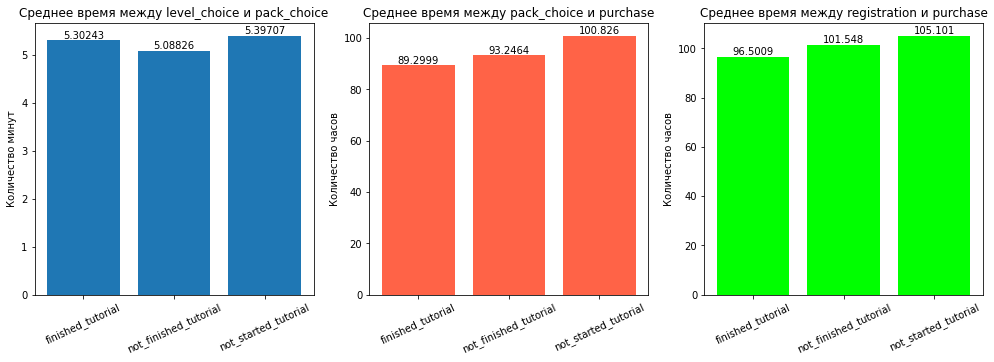

In [ ]:
# Создаем сводную таблицу с подсчетом среднего и форматируем в обычный датафрейм.
pivot = user_event_times_df[
    ['user_group','lvl_choice_to_pack_choice', 'pack_choice_to_purchase', 'total_time']
].pivot_table(
    index='user_group',
    aggfunc='mean'
).reset_index(drop=False).rename_axis(None, axis=1)

# Считаем насколько быстрее пользователи из группы finished_tutorial проходят этапы быстрее пользователей из группы not_started_tutorial.
avg1 = abs((pivot.iloc[0][2] / pivot.iloc[2][2]) - 1)
avg2 = abs((pivot.iloc[0][3] / pivot.iloc[2][3]) - 1)

# Строим столбчатые диаграммы.
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(17,5))

axes[0].bar(
    x=pivot.user_group,
    height=pivot.lvl_choice_to_pack_choice
)
axes[0].set_title('Среднее время между level_choice и pack_choice')
axes[0].set_ylabel('Количество минут')
axes[0].xaxis.set_tick_params(rotation=25)

axes[1].bar(
    x=pivot.user_group,
    height=pivot.pack_choice_to_purchase,
    color='tomato'
)
axes[1].set_title('Среднее время между pack_choice и purchase')
axes[1].set_ylabel('Количество часов')
axes[1].xaxis.set_tick_params(rotation=25)

axes[2].bar(
    x=pivot.user_group,
    height=pivot.total_time,
    color='lime'
)
axes[2].set_title('Среднее время между registration и purchase')
axes[2].set_ylabel('Количество часов')
axes[2].xaxis.set_tick_params(rotation=25)

axes[0].bar_label(axes[0].containers[0], label_type='edge')
axes[1].bar_label(axes[1].containers[0], label_type='edge')
axes[2].bar_label(axes[2].containers[0], label_type='edge')

display(pivot)

print(
    'В среднем пользователи с завершенным обучением проходят этап между pack_choice и purchase на {:.2%} быстрее не начинавших обучение пользователей.'.format(avg1)
)
print(
    'В среднем пользователи с завершенным обучением проходят весь путь от registration до purchase на {:.2%} быстрее не начинавших обучение пользователей.'.format(avg2)
)

##### Выводы:
Как видно из графиков, прохождение обучения явно влияет на скорость прохождения других этапов игры.
В отношении этапа между выбором уровня сложности и пакета с бесплатными вопросами четкие выводы сделать сложно, так как у всех трех групп пользователей в среднем уходило чуть более 5 минут на прохождение этого этапа.

Но если посмотреть на следующий этап и на весь путь пользователя (от регистрации до покупки), то становится заметна закономерность - прохождение обучения положительно влияет на решение пользователя о совершении покупки. Что интересно, пользователи, не прошедшие обучение до конца, тоже быстрее проходят все этапы игры по сравнению с теми, кто обучение так и не начинал.

В среднем пользователи с завершенным обучением проходят этап между pack_choice и purchase на 11.43% быстрее не начинавших обучение пользователей.

В среднем пользователи с завершенным обучением проходят весь путь от registration до purchase на 8.18% быстрее не начинавших обучение пользователей.

#### Гипотеза №2:

Для проверки гипотезы строим таблицу, в которой делим пользователй на группы в зависимости от количества начатых обучений, также считаем какое количество пользователей из каждой группы совершили оплату.

In [ ]:
# Создаем список пользователей, совершивших оплату.
users_with_purchase = total_events_2018[total_events_2018.event_type == 'purchase'].user_id.to_list()

# Создаем таблицу с подсчетом количества начатых обучений для каждого пользователя и проверяем наличие оплаты.
tutorial_count = total_events_2018.groupby('user_id').tutorial_id.nunique().to_frame().reset_index()
tutorial_count['purchase'] = tutorial_count.user_id.apply(lambda x: 1 if x in set(users_with_purchase) else 0)
tutorial_count = tutorial_count.rename(columns={'tutorial_id':'tutorial_count'})

# На основании таблицы создаем сводную с группировкой по количеству пройденных обучений. 
# Форматируем сводную таблицу в обычный датафрейм. 
tutorial_count_pivot = tutorial_count.pivot_table(
    index='tutorial_count',
    aggfunc={'user_id':'count', 'purchase':'sum'}
).reset_index()

# Считаем конверсию пользователей в клиенты. Переименовываем столбцы для наглядности.
tutorial_count_pivot['conversion'] = round((tutorial_count_pivot.purchase / tutorial_count_pivot.user_id) * 100, 2)
tutorial_count_pivot = tutorial_count_pivot.rename(columns={'user_id':'users',
                                                            'purchase': 'purchases'})
tutorial_count_pivot['percent_users'] = (tutorial_count_pivot.users / len(all_users)) * 100

users_with_many_tutorials = tutorial_count_pivot.query('tutorial_count > 1').percent_users.sum()

Строим визуализацию:

,tutorial_count,purchases,users,conversion,percent_users
0,0,22,8068,0.27,40.489812
1,1,1207,9103,13.26,45.684031
2,2,218,1589,13.72,7.974506
3,3,51,427,11.94,2.142929
4,4,30,221,13.57,1.109104
5,5,16,109,14.68,0.547024
6,6,14,116,12.07,0.582154
7,7,12,94,12.77,0.471745
8,8,13,86,15.12,0.431597
9,9,17,113,15.04,0.567098


Процент пользователей, проходивших обучение более 1-го раза: 13.83%


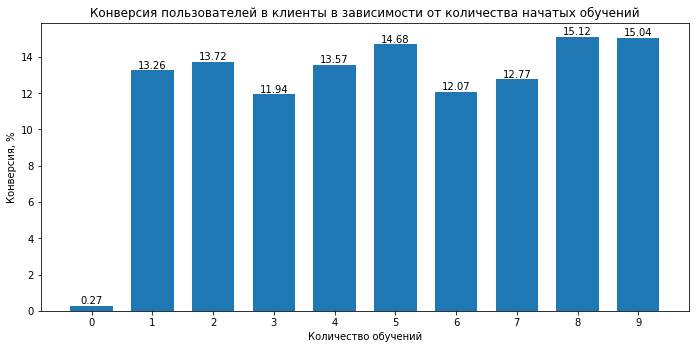

In [ ]:
fig = plt.figure(figsize=(9, 4))
main_axes = fig.add_axes([0, 0, 1, 1])
main_axes.bar(
    x = tutorial_count_pivot.tutorial_count,
    height = tutorial_count_pivot.conversion,
    width=0.7
)

main_axes.set_xticks(tutorial_count_pivot.tutorial_count)
main_axes.set_xlabel('Количество обучений')
main_axes.set_ylabel('Конверсия, %')
main_axes.set_title('Конверсия пользователей в клиенты в зависимости от количества начатых обучений')
main_axes.bar_label(main_axes.containers[0])

display(tutorial_count_pivot)

print(
    'Процент пользователей, проходивших обучение более 1-го раза: {:.4}%'.format(users_with_many_tutorials)
)

##### Выводы:

Исследование показывает, что прохождение обучения влияет на решение пользователя о последующей оплате. Лишь 0.27% не прошедших обучение пользователей в последствии решили совершить покупку в приложении. При этом, в остальных группах конверсия находится в диапазоне от 12% до 15%, что является хорошим показателем для мобильных игр (в среднем по индустрии этот показатель составляет 2-3%, согласно рекламному агенству TapJoy).

Стоит отметить, что достаточное количество пользователей (13.83%) прошли обучении более одного раза, что может говорить о том, что приложение недостаточно интуитивно и следует обратить внимание непосредственно на интерфейс приложения и на содержимое самого обучения.

#### Гипотеза №3:

In [ ]:
# Создаем два датафрейма с событиями начала обучения и выбора уровня сложности.
tutorial_start_df = total_events_2018[total_events_2018.event_type == 'tutorial_start']
level_choice_df = total_events_2018[total_events_2018.event_type == 'level_choice']

# Объединяем датафреймы.
merged_df = tutorial_start_df[['user_id','start_time']].merge(
    level_choice_df[['user_id','start_time']],
    how='inner',
    on='user_id',
    suffixes=('_ts','_lc')
)
merged_df = merged_df.rename(columns={'start_time_ts': 'tutorial_start',
                                      'start_time_lc': 'level_choice'})

# Создаем столбец с подсчетом времени между выбором уровня и началом обучения.
merged_df['timedelta'] = (merged_df.level_choice - merged_df.tutorial_start) / pd.Timedelta('1 hour')

# Считаем количество пользователей, дошедших до этапа выбора сложности, и пользователей, начавших обучение после выбора сложности.

confused_users = merged_df.query('timedelta < 0').user_id.nunique()
users_with_level_choice = total_events_2018[total_events_2018.event_type == 'level_choice'].user_id.to_list()

percentage = (confused_users / len(set(users_with_level_choice)))
print(
    'Количество пользователей, начавших обучение после выбора уровня сложности:', confused_users
)
print(
    'Процент пользователей с началом обучения после выбора уровня сложности по отношению к общему количеству пользователей, выбравших уровень сложности: {:.2%}'.format(percentage)
)

Количество пользователей, начавших обучение после выбора уровня сложности: 1386
Процент пользователей с началом обучения после выбора уровня сложности по отношению к общему количеству пользователей, выбравших уровень сложности: 16.61%


##### Выводы:
1386 пользователей начали обучение после выбора уровня сложности, что составляет 16.61% от всех пользователей, выбравших уровень сложности. Это высокий процент, который говорит о том, что пользователям не до конца понятен процесс взаимодействия с игрой.

#### Заключение:
В целом, принимая во внимание результаты исследования гипотез, стоит отметить, что наша мобильная игра имеет высокий показатель конверсии. Следует обратить внимание на интерфейс, чтобы заинтересовать пользователя в прохождении обучения (возможно мотивировать при помощи дополнительной награды за успешное прохождение обучения), так как в итоге оно положительно влияет на решение пользователя о совершении покупки. Также стоит уделить внимание непосредственно содержанию обучения, чтобы процесс взаимодействия с игрой стал более прозрачным.